### Event-Based Backtesting

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

In [15]:

class BacktestBase(object):
    ''' Base class for event-based backtesting of trading strategies.
    Attributes
    ==========
    symbol: str
        TR RIC (financial instrument) to be used
    start: str
        start date for data selection
    end: str
        end date for data selection
    amount: float
        amount to be invested either once or per trade
    ftc: float
        fixed transaction costs per trade (buy or sell)
    ptc: float
        proportional transaction costs per trade (buy or sell)
    Methods
    =======
    get_data:
        retrieves and prepares the base data set
    plot_data:
        plots the closing price for the symbol
    get_date_price:
        returns the date and price for the given bar
    print_balance:
        prints out the current (cash) balance
    print_net_wealth:
        prints out the current net wealth
    place_buy_order:
        places a buy order
    place_sell_order:
        places a sell order
    close_out:
        closes out a long or short position
    '''

    def __init__(self, symbol, start, end, amount,
                 ftc=0.0, ptc=0.0, verbose=True):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.initial_amount = amount
        self.amount = amount
        self.ftc = ftc
        self.ptc = ptc
        self.units = 0
        self.position = 0
        self.trades = 0
        self.verbose = verbose
        self.get_data()

    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = yf.download(self.symbol, start=self.start, end=self.end)[['Adj Close']].copy()
        raw.rename(columns={'Adj Close': 'price'}, inplace=True)
        raw['return'] = np.log(raw / raw.shift(1))
        self.data = raw.dropna()

    def plot_data(self, cols=None):
        ''' Plots the closing prices for symbol.
        '''
        if cols is None:
            cols = ['price']
        self.data[cols].plot(figsize=(10, 6), title=self.symbol)

    def get_date_price(self, bar):
        ''' Return date and price for bar.
        '''
        date = str(self.data.index[bar])[:10]
        price = self.data.price.iloc[bar]
        return date, price

    def print_balance(self, bar):
        ''' Print out current cash balance info.
        '''
        date, price = self.get_date_price(bar)
        print(f'{date} | current balance {self.amount:.2f}')

    def print_net_wealth(self, bar):
        ''' Print out current cash balance info.
        '''
        date, price = self.get_date_price(bar)
        net_wealth = self.units * price + self.amount
        print(f'{date} | current net wealth {net_wealth:.2f}')

    def place_buy_order(self, bar, units=None, amount=None):
        ''' Place a buy order.
        '''
        date, price = self.get_date_price(bar)
        if units is None:
            units = int(amount / price)
        self.amount -= (units * price) * (1 + self.ptc) + self.ftc
        self.units += units
        self.trades += 1
        if self.verbose:
            print(f'{date} | buying {units} units at {price:.2f}')
            self.print_balance(bar)
            self.print_net_wealth(bar)

    def place_sell_order(self, bar, units=None, amount=None):
        ''' Place a sell order.
        '''
        date, price = self.get_date_price(bar)
        if units is None:
            units = int(amount / price)
        self.amount += (units * price) * (1 - self.ptc) - self.ftc
        self.units -= units
        self.trades += 1
        if self.verbose:
            print(f'{date} | selling {units} units at {price:.2f}')
            self.print_balance(bar)
            self.print_net_wealth(bar)

    def close_out(self, bar):
        ''' Closing out a long or short position.
        '''
        date, price = self.get_date_price(bar)
        self.amount += self.units * price
        self.units = 0
        self.trades += 1
        if self.verbose:
            print(f'{date} | inventory {self.units} units at {price:.2f}')
            print('=' * 55)
        print('Final balance   [$] {:.2f}'.format(self.amount))
        perf = ((self.amount - self.initial_amount) /
                self.initial_amount * 100)
        print('Net Performance [%] {:.2f}'.format(perf))
        print('Trades Executed [#] {}'.format(self.trades))
        print('=' * 55)

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2514 entries, 2010-01-05 to 2019-12-30
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   2514 non-null   float64
 1   return  2514 non-null   float64
dtypes: float64(2)
memory usage: 58.9 KB
None
                price    return
Date                           
2019-12-23  69.871780  0.016187
2019-12-24  69.938202  0.000950
2019-12-26  71.325806  0.019646
2019-12-27  71.298729 -0.000380
2019-12-30  71.721901  0.005918


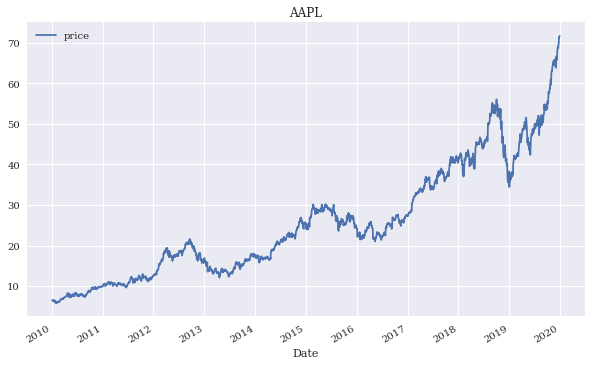

In [16]:
bb = BacktestBase('AAPL', '2010-01-01', '2019-12-31', 10000)
print(bb.data.info())
print(bb.data.tail())
bb.plot_data()

### Long-Only Backtesting Class

In [24]:
class BacktestLongOnly(BacktestBase):
    
    def run_mean_reversion_strategy(self, SMA, threshold):
        ''' Backtesting a mean reversion-based strategy.
        Parameters
        ==========
        SMA: int
            simple moving average in days
        threshold: float
            absolute value for deviation-based signal relative to SMA
        '''
        msg = f'\n\nRunning mean reversion strategy : {self.symbol}\n'
        msg += f'SMA={SMA} & thr={threshold}'
        msg += f'\nfixed costs {self.ftc} | '
        msg += f'proportional costs {self.ptc}'
        # print parameters of backtesting!
        print(msg)
        print('=' * 55)
        # set position to market neutral
        self.position = 0
        self.trades = 0
        # current cash amount overriden as initial amount
        # in case you ran this backtester before
        self.amount = self.initial_amount

        self.data['SMA'] = self.data['price'].rolling(SMA).mean()

        # the length of the SMA determines the start of the history
        for bar in range(SMA, len(self.data)):
            # if you're market neutral...
            if self.position == 0:
                # if its essentially a low outlier, buy!
                if (self.data['price'].iloc[bar] <
                        self.data['SMA'].iloc[bar] - threshold):
                    # buy with the whole cash balance (stupid)
                    self.place_buy_order(bar, amount=self.amount)
                    # market position set to long!
                    self.position = 1
            # if you're long...
            elif self.position == 1:
                # if its essentially a high outlier, sell!
                if self.data['price'].iloc[bar] >= self.data['SMA'].iloc[bar]:
                    # sell all of the stocks (stupid?)
                    self.place_sell_order(bar, units=self.units)
                    # market position set to neutral
                    self.position = 0
        # close out market position
        self.close_out(bar)

    def run_sma_strategy(self, SMA1, SMA2):
        ''' Backtesting a SMA-based strategy.
        Parameters
        ==========
        SMA1, SMA2: int
            shorter and longer term simple moving average (in days)
        '''
        msg = f'\n\nRunning SMA strategy : {self.symbol}\n SMA1={SMA1} & SMA2={SMA2}'
        msg += f'\nfixed costs {self.ftc} | '
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 55)
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.amount = self.initial_amount  # reset initial capital
        self.data['SMA1'] = self.data['price'].rolling(SMA1).mean()
        self.data['SMA2'] = self.data['price'].rolling(SMA2).mean()

        for bar in range(SMA2, len(self.data)):
            if self.position == 0:
                if self.data['SMA1'].iloc[bar] > self.data['SMA2'].iloc[bar]:
                    self.place_buy_order(bar, amount=self.amount)
                    self.position = 1  # long position
            elif self.position == 1:
                if self.data['SMA1'].iloc[bar] < self.data['SMA2'].iloc[bar]:
                    self.place_sell_order(bar, units=self.units)
                    self.position = 0  # market neutral
        self.close_out(bar)

    def run_momentum_strategy(self, momentum):
        ''' Backtesting a momentum-based strategy.
        Parameters
        ==========
        momentum: int
            number of days for mean return calculation
        '''
        msg = f'\n\nRunning momentum strategy : {self.symbol}\n{momentum} days'
        msg += f'\nfixed costs {self.ftc} | '
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 55)
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.amount = self.initial_amount  # reset initial capital
        self.data['momentum'] = self.data['return'].rolling(momentum).mean()
        for bar in range(momentum, len(self.data)):
            if self.position == 0:
                if self.data['momentum'].iloc[bar] > 0:
                    self.place_buy_order(bar, amount=self.amount)
                    self.position = 1  # long position
            elif self.position == 1:
                if self.data['momentum'].iloc[bar] < 0:
                    self.place_sell_order(bar, units=self.units)
                    self.position = 0  # market neutral
        self.close_out(bar)

In [22]:
bb = BacktestLongOnly('AAPL', '2010-01-01', '2019-12-31', 10000)
bb.run_mean_reversion_strategy(50,5)

[*********************100%***********************]  1 of 1 completed


Running mean reversion strategy : AAPL
SMA=50 & thr=5
fixed costs 0.0 | proportional costs 0.0
2018-11-12 | buying 212 units at 47.06
2018-11-12 | current balance 22.43
2018-11-12 | current net wealth 10000.00
2019-01-30 | selling 212 units at 40.05
2019-01-30 | current balance 8513.93
2019-01-30 | current net wealth 8513.93
2019-06-03 | buying 201 units at 42.35
2019-06-03 | current balance 1.97
2019-06-03 | current net wealth 8513.93
2019-06-11 | selling 201 units at 47.60
2019-06-11 | current balance 9570.43
2019-06-11 | current net wealth 9570.43
2019-12-30 | inventory 0 units at 71.72
Final balance   [$] 9570.43
Net Performance [%] -4.30
Trades Executed [#] 5


In [27]:
def run_strategies():
        lobt.run_sma_strategy(42, 252)
        lobt.run_momentum_strategy(60)
        lobt.run_mean_reversion_strategy(50, 5)
        
lobt = BacktestLongOnly('AAPL', '2010-01-01', '2019-12-31', 10000,
                        verbose=False)
run_strategies()
# transaction costs: 10 USD fix, 1% variable
lobt = BacktestLongOnly('AAPL', '2010-01-01', '2019-12-31',
                        10000, 10.0, 0.01, False)
run_strategies()

[*********************100%***********************]  1 of 1 completed


Running SMA strategy : AAPL
 SMA1=42 & SMA2=252
fixed costs 0.0 | proportional costs 0.0
Final balance   [$] 56093.87
Net Performance [%] 460.94
Trades Executed [#] 8


Running momentum strategy : AAPL
60 days
fixed costs 0.0 | proportional costs 0.0
Final balance   [$] 92565.35
Net Performance [%] 825.65
Trades Executed [#] 120


Running mean reversion strategy : AAPL
SMA=50 & thr=5
fixed costs 0.0 | proportional costs 0.0
Final balance   [$] 9570.43
Net Performance [%] -4.30
Trades Executed [#] 5
[*********************100%***********************]  1 of 1 completed


Running SMA strategy : AAPL
 SMA1=42 & SMA2=252
fixed costs 10.0 | proportional costs 0.01
Final balance   [$] 52870.18
Net Performance [%] 428.70
Trades Executed [#] 8


Running momentum strategy : AAPL
60 days
fixed costs 10.0 | proportional costs 0.01
Final balance   [$] 26164.28
Net Performance [%] 161.64
Trades Executed [#] 120


Running mean reve

-In other backtesting notebooks, we saw the importance of classification accuracy and market timing. Now we see the importance of **number of trades**. The golden cross strategy shined in both the experiments with no transaction costs and with transaction costs. The momentum strategy
practically 10xed the money without transactions costs but was greatly degraded with fees. The
mean reversion performed poorly in both cases. NEED TO GET AN OPTIMIZER WORKING ON THESE ALGS!!!

In [28]:
def run_strategies():
        lobt.run_sma_strategy(42, 252)
        lobt.run_momentum_strategy(60)
        lobt.run_mean_reversion_strategy(50, 5)
        
lobt = BacktestLongOnly('AAPL', '2020-03-15', '2022-02-01', 10000,
                        verbose=False)
run_strategies()
# transaction costs: 10 USD fix, 1% variable
lobt = BacktestLongOnly('AAPL', '2020-03-15', '2022-02-01',
                        10000, 10.0, 0.01, False)
run_strategies()

[*********************100%***********************]  1 of 1 completed


Running SMA strategy : AAPL
 SMA1=42 & SMA2=252
fixed costs 0.0 | proportional costs 0.0
Final balance   [$] 14042.78
Net Performance [%] 40.43
Trades Executed [#] 2


Running momentum strategy : AAPL
60 days
fixed costs 0.0 | proportional costs 0.0
Final balance   [$] 18527.12
Net Performance [%] 85.27
Trades Executed [#] 18


Running mean reversion strategy : AAPL
SMA=50 & thr=5
fixed costs 0.0 | proportional costs 0.0
Final balance   [$] 11845.73
Net Performance [%] 18.46
Trades Executed [#] 9
[*********************100%***********************]  1 of 1 completed


Running SMA strategy : AAPL
 SMA1=42 & SMA2=252
fixed costs 10.0 | proportional costs 0.01
Final balance   [$] 13933.56
Net Performance [%] 39.34
Trades Executed [#] 2


Running momentum strategy : AAPL
60 days
fixed costs 10.0 | proportional costs 0.01
Final balance   [$] 15491.33
Net Performance [%] 54.91
Trades Executed [#] 18


Running mean reversion

### Long-Short 

In [29]:
class BacktestLongShort(BacktestBase):

    def go_long(self, bar, units=None, amount=None):
        # closing the short sell position
        if self.position == -1:
            self.place_buy_order(bar, units=-self.units)
        # otherwise if you're not shorting, specif units or amount
        if units:
            self.place_buy_order(bar, units=units)
        elif amount:
            if amount == 'all':
                amount = self.amount
            self.place_buy_order(bar, amount=amount)

    def go_short(self, bar, units=None, amount=None):
        # go market neutral if you're already long
        if self.position == 1:
            self.place_sell_order(bar, units=self.units)
        if units:
            self.place_sell_order(bar, units=units)
        elif amount:
            if amount == 'all':
                amount = self.amount
            self.place_sell_order(bar, amount=amount)

    def run_sma_strategy(self, SMA1, SMA2):
        msg = f'\n\nRunning SMA strategy | SMA1={SMA1} & SMA2={SMA2}'
        msg += f'\nfixed costs {self.ftc} | '
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 55)
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.amount = self.initial_amount  # reset initial capital
        self.data['SMA1'] = self.data['price'].rolling(SMA1).mean()
        self.data['SMA2'] = self.data['price'].rolling(SMA2).mean()

        for bar in range(SMA2, len(self.data)):
            if self.position in [0, -1]:
                if self.data['SMA1'].iloc[bar] > self.data['SMA2'].iloc[bar]:
                    # here specifying the amount means going long and not neutral
                    self.go_long(bar, amount='all')
                    self.position = 1  # long position
            if self.position in [0, 1]:
                if self.data['SMA1'].iloc[bar] < self.data['SMA2'].iloc[bar]:
                    self.go_short(bar, amount='all')
                    self.position = -1  # short position
        self.close_out(bar)

    def run_momentum_strategy(self, momentum):
        msg = f'\n\nRunning momentum strategy | {momentum} days'
        msg += f'\nfixed costs {self.ftc} | '
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 55)
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.amount = self.initial_amount  # reset initial capital
        self.data['momentum'] = self.data['return'].rolling(momentum).mean()
        for bar in range(momentum, len(self.data)):
            if self.position in [0, -1]:
                if self.data['momentum'].iloc[bar] > 0:
                    # here specifying the amount means going long and not neutral
                    self.go_long(bar, amount='all')
                    self.position = 1  # long position
            if self.position in [0, 1]:
                if self.data['momentum'].iloc[bar] <= 0:
                    self.go_short(bar, amount='all')
                    self.position = -1  # short position
        self.close_out(bar)

    def run_mean_reversion_strategy(self, SMA, threshold):
        msg = f'\n\nRunning mean reversion strategy | '
        msg += f'SMA={SMA} & thr={threshold}'
        msg += f'\nfixed costs {self.ftc} | '
        msg += f'proportional costs {self.ptc}'
        print(msg)
        print('=' * 55)
        self.position = 0  # initial neutral position
        self.trades = 0  # no trades yet
        self.amount = self.initial_amount  # reset initial capital

        self.data['SMA'] = self.data['price'].rolling(SMA).mean()

        for bar in range(SMA, len(self.data)):
            # three scenarios here: when you're neutral, long and short
            if self.position == 0:
                if (self.data['price'].iloc[bar] <
                        self.data['SMA'].iloc[bar] - threshold):
                    self.go_long(bar, amount=self.initial_amount)
                    self.position = 1
                elif (self.data['price'].iloc[bar] >
                        self.data['SMA'].iloc[bar] + threshold):
                    self.go_short(bar, amount=self.initial_amount)
                    self.position = -1
            # if you're long and simply above trend line, you go neutral
            elif self.position == 1:
                if self.data['price'].iloc[bar] >= self.data['SMA'].iloc[bar]:
                    self.place_sell_order(bar, units=self.units)
                    self.position = 0
            # if you're short and simply below trend line, you go neutral
            elif self.position == -1:
                if self.data['price'].iloc[bar] <= self.data['SMA'].iloc[bar]:
                    self.place_buy_order(bar, units=-self.units)
                    self.position = 0
        self.close_out(bar)

In [30]:
def run_strategies():
    lsbt.run_sma_strategy(42, 252)
    lsbt.run_momentum_strategy(60)
    lsbt.run_mean_reversion_strategy(50, 5)
    
lsbt = BacktestLongShort('AAPL', '2010-1-1', '2019-12-31', 10000,
                            verbose=False)
run_strategies()

# transaction costs: 10 USD fix, 1% variable
lsbt = BacktestLongShort('AAPL', '2010-1-1', '2019-12-31',
                            10000, 10.0, 0.01, False)
run_strategies()

[*********************100%***********************]  1 of 1 completed


Running SMA strategy | SMA1=42 & SMA2=252
fixed costs 0.0 | proportional costs 0.0
Final balance   [$] 37875.45
Net Performance [%] 278.75
Trades Executed [#] 14


Running momentum strategy | 60 days
fixed costs 0.0 | proportional costs 0.0
Final balance   [$] 75551.29
Net Performance [%] 655.51
Trades Executed [#] 238


Running mean reversion strategy | SMA=50 & thr=5
fixed costs 0.0 | proportional costs 0.0
Final balance   [$] 7524.03
Net Performance [%] -24.76
Trades Executed [#] 10
[*********************100%***********************]  1 of 1 completed


Running SMA strategy | SMA1=42 & SMA2=252
fixed costs 10.0 | proportional costs 0.01
Final balance   [$] 32939.46
Net Performance [%] 229.39
Trades Executed [#] 14


Running momentum strategy | 60 days
fixed costs 10.0 | proportional costs 0.01
Final balance   [$] 4834.38
Net Performance [%] -51.66
Trades Executed [#] 238


Running mean reversion strategy | SMA=50 